In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Process Data

In [3]:

# Load the dataset
print("Loading the dataset...")
df = pd.read_csv('merged_players_with_fees.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Data preprocessing
print("\nPreprocessing data...")

# Clean the 'Transfer Fee' column (remove € symbol and convert to float)
df['Transfer Fee'] = df['Transfer Fee'].str.replace('€', '').str.replace('M', '').astype(float)

# Handle Age column (format like "26-129" where 26 is years and 129 is days)
# Extract just the years part for simplicity
df['Age'] = df['Age'].apply(lambda x: int(x.split('-')[0]) if isinstance(x, str) else x)

# Keep only the columns we need for modeling
# First, identify which columns are likely to be numeric
print("\nIdentifying numeric columns...")
numeric_columns = ['Age', 'Transfer Fee']  # Start with columns we know are numeric
for col in df.columns:
    if col not in ['Player', 'Nation', 'Team', 'Position', 'Age', 'Transfer Fee']:
        # Try to convert a sample to check if it's numeric
        try:
            sample = df[col].iloc[0]
            if isinstance(sample, str):
                if sample == 'N/a':
                    # This is likely a numeric column with missing values
                    numeric_columns.append(col)
                elif re.match(r'^[-+]?\d*\.?\d+$', sample.replace(',', '')):
                    # This is likely a numeric column
                    numeric_columns.append(col)
            else:
                # If it's not a string, it's likely already numeric
                numeric_columns.append(col)
        except:
            print(f"Skipping column: {col}")

print(f"Found {len(numeric_columns)} potentially numeric columns")

# Create a new dataframe with only the columns we want to use
print("\nCreating a clean dataframe with only numeric columns...")
model_df = df[numeric_columns].copy()

# Replace 'N/a' with NaN
model_df.replace('N/a', np.nan, inplace=True)

# Convert all columns to numeric
for col in model_df.columns:
    if col not in ['Player', 'Nation', 'Team', 'Position']:
        try:
            model_df[col] = pd.to_numeric(model_df[col], errors='coerce')
        except Exception as e:
            print(f"Error converting {col} to numeric: {e}")

# Check if we have any remaining non-numeric columns
print("\nChecking for non-numeric columns...")
for col in model_df.columns:
    if not pd.api.types.is_numeric_dtype(model_df[col]):
        print(f"Column {col} is not numeric: {model_df[col].dtype}")
        # Drop non-numeric columns
        model_df = model_df.drop(columns=[col])

# Fill NaN values with median (more robust than mean)
model_df = model_df.fillna(model_df.median())

Loading the dataset...
Dataset shape: (275, 79)

First few rows:
               Player Nation            Team Position     Age  Matches played  \
0      Aaron Ramsdale    ENG     Southampton       GK  26-353              26   
1   Aaron Wan-Bissaka    ENG        West Ham       DF  27-157              32   
2  Abdoulaye Doucouré    MLI         Everton       MF  32-121              30   
3          Adam Smith    ENG     Bournemouth       DF  34-003              22   
4        Adam Wharton    ENG  Crystal Palace       MF  20-334              19   

   Starts Minutes  Goals  Assists  ...  \
0      26   2,340      0        0  ...   
1      31   2,794      2        2  ...   
2      29   2,425      3        1  ...   
3      17   1,409      0        0  ...   
4      15   1,258      0        2  ...   

   Progressive Passes Received in Receiving  Fouls Committed  Fouls Drawn  \
0                                         0                1            4   
1                                       1

# Prepare Dataset

In [4]:

# Print some statistics about the target variable
print("\nTransfer Fee statistics:")
print(model_df['Transfer Fee'].describe())

# Prepare features and target
X = model_df.drop(['Transfer Fee'], axis=1)
y = model_df['Transfer Fee']

# Display the shape of our feature matrix
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Transfer Fee statistics:
count    275.000000
mean      34.276364
std       25.969631
min        0.900000
25%       15.950000
50%       28.500000
75%       49.300000
max      198.800000
Name: Transfer Fee, dtype: float64

Feature matrix shape: (275, 74)
Target vector shape: (275,)


# Model to get top 10 importance feature


Training LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3202
[LightGBM] [Info] Number of data points in the train set: 220, number of used features: 69
[LightGBM] [Info] Start training from score 33.118636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

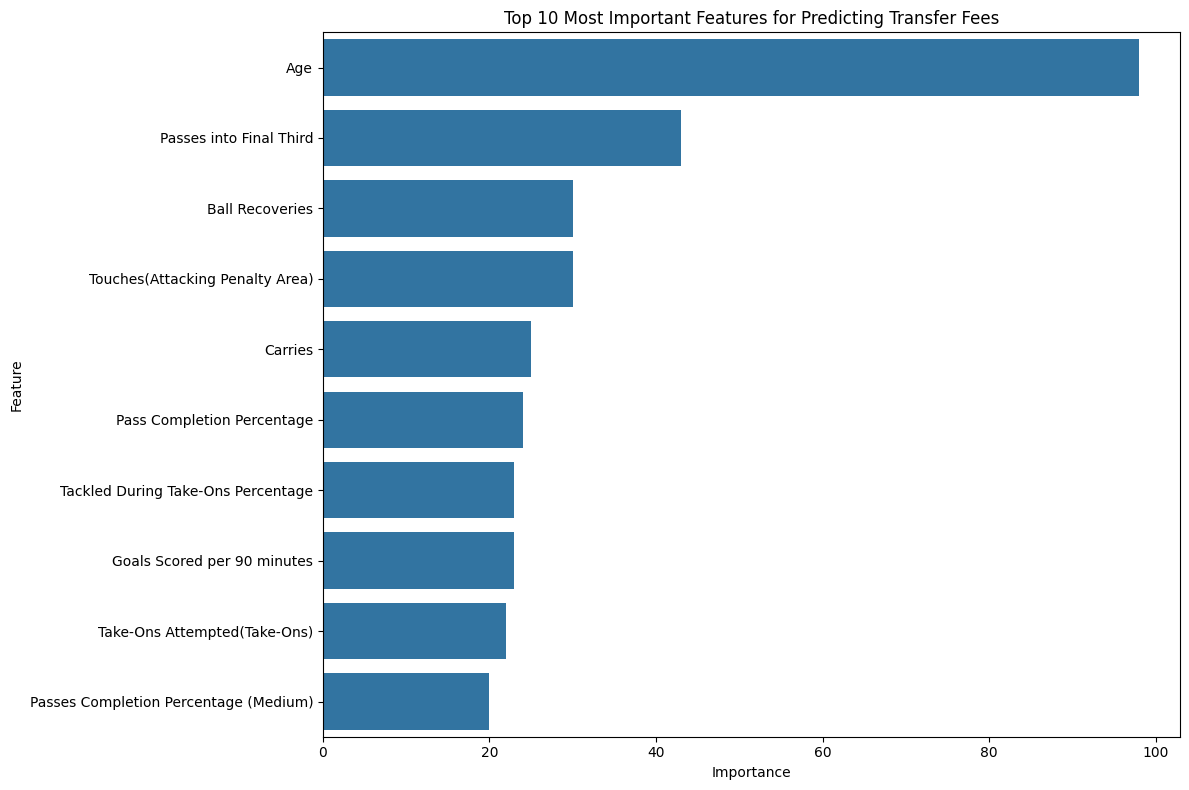

In [9]:

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a LightGBM model
print("\nTraining LightGBM model...")
model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=100,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    random_state=42
)

# Use scaled features
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# Get feature importances
feature_importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame to store feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Display the top 10 most important features
print("\nTop 10 Most Important Features:")
top_10_features = importance_df.head(10)
print(top_10_features)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_10_features)
plt.title('Top 10 Most Important Features for Predicting Transfer Fees')
plt.tight_layout()
plt.savefig('feature_importance.png')
print("\nFeature importance plot saved as 'feature_importance.png'")

# Train a new model using only the top 10 features
print("\nTraining a new model with only the top 10 features...")
top_features = top_10_features['Feature'].tolist()
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]


# Train model to predict value of player based on top 10 importance features

In [10]:

# Create a new scaler for the top 10 features
scaler_top10 = StandardScaler()
X_train_top_scaled = scaler_top10.fit_transform(X_train_top)
X_test_top_scaled = scaler_top10.transform(X_test_top)

model_top10 = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=100,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    random_state=42
)

# Use scaled features
model_top10.fit(X_train_top_scaled, y_train)

# Make predictions with the top 10 features model
y_pred_top10 = model_top10.predict(X_test_top_scaled)

# Evaluate the top 10 features model
mse_top10 = mean_squared_error(y_test, y_pred_top10)
rmse_top10 = np.sqrt(mse_top10)
r2_top10 = r2_score(y_test, y_pred_top10)

print(f"\nModel Performance with Top 10 Features:")
print(f"RMSE: {rmse_top10:.2f}")
print(f"R²: {r2_top10:.2f}")

# Compare original model vs top 10 features model
print("\nComparison:")
print(f"Full Model - RMSE: {rmse:.2f}, R²: {r2:.2f}")
print(f"Top 10 Features Model - RMSE: {rmse_top10:.2f}, R²: {r2_top10:.2f}")

# Print description of top 10 features for better understanding
print("\nDescription of Top 10 Features:")
for feature in top_features:
    print(f"- {feature}")
    print(f"  Mean: {X[feature].mean():.2f}")
    print(f"  Min: {X[feature].min():.2f}")
    print(f"  Max: {X[feature].max():.2f}")
    print(f"  Correlation with Transfer Fee: {X[feature].corr(y):.2f}")
    print() 


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 538
[LightGBM] [Info] Number of data points in the train set: 220, number of used features: 10
[LightGBM] [Info] Start training from score 33.118636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

# Save model

In [11]:
import pickle
with open('lightgbm_model.pkl', 'wb') as f:
    pickle.dump(model_top10, f)

with open('top10_scaler.pkl', 'wb') as f:
    pickle.dump(scaler_top10, f)

with open('top10_features.pkl', 'wb') as f:
    pickle.dump(top_features, f)

# Test the model with example players
print("\n===== TEST MODEL WITH EXAMPLE PLAYERS =====")

# Print the exact column names for reference
print("\nExact column names from top features:")
for feature in top_features:
    print(f"- '{feature}'")



===== TEST MODEL WITH EXAMPLE PLAYERS =====

Exact column names from top features:
- 'Age'
- 'Passes into Final Third'
- 'Ball Recoveries'
- 'Touches(Attacking Penalty Area)'
- 'Carries'
- 'Pass Completion Percentage'
- 'Tackled During Take-Ons Percentage'
- 'Goals Scored per 90 minutes'
- 'Take-Ons Attempted(Take-Ons)'
- 'Passes Completion Percentage (Medium)'


# Example

In [12]:

# Create example players with their statistics
example_players = [
    {
        'name': 'Kylian Mbappé',
        'Age': 23,
        'Passes into Final Third': 85,
        'Ball Recoveries': 72,
        'Touches(Attacking Penalty Area)': 195,
        'Carries': 780,
        'Pass Completion %': 83.2,
        'Tackled During Take-On %': 27.5,
        'Goals/90': 0.92,
        'Take-Ons Attempted': 120,
        'Pass Completion %(Medium)': 85.7
    },
    {
        'name': 'Luka Modrić',
        'Age': 36,
        'Passes into Final Third': 210,
        'Ball Recoveries': 105,
        'Touches(Attacking Penalty Area)': 40,
        'Carries': 690,
        'Pass Completion %': 91.5,
        'Tackled During Take-On %': 18.0,
        'Goals/90': 0.12,
        'Take-Ons Attempted': 35,
        'Pass Completion %(Medium)': 94.2
    },
    {
        'name': 'Phil Foden',
        'Age': 22,
        'Passes into Final Third': 95,
        'Ball Recoveries': 65,
        'Touches(Attacking Penalty Area)': 110,
        'Carries': 750,
        'Pass Completion %': 87.0,
        'Tackled During Take-On %': 31.0,
        'Goals/90': 0.55,
        'Take-Ons Attempted': 85,
        'Pass Completion %(Medium)': 89.5
    }
]

# Create a dictionary to map our column names to the model's expected column names
column_mapping = {
    'Pass Completion %': 'Pass Completion Percentage',
    'Tackled During Take-On %': 'Tackled During Take-Ons Percentage',
    'Goals/90': 'Goals Scored per 90 minutes',
    'Take-Ons Attempted': 'Take-Ons Attempted(Take-Ons)',
    'Pass Completion %(Medium)': 'Passes Completion Percentage (Medium)'
}

# Create DataFrame from example players
example_df = pd.DataFrame(example_players)

# Rename columns to match the model's expected column names
for old_col, new_col in column_mapping.items():
    if old_col in example_df.columns:
        example_df[new_col] = example_df[old_col]
        example_df.drop(columns=[old_col], inplace=True)

# Extract features for prediction
X_example = example_df[top_features].copy()

# Scale the features
X_example_scaled = scaler_top10.transform(X_example)

# Make predictions
predictions = model_top10.predict(X_example_scaled)

# Display the results
print("\nPredicted Transfer Values:")
for i, player in enumerate(example_players):
    predicted_fee = predictions[i]
    print(f"\nPlayer: {player['name']}")
    print(f"Age: {player['Age']}")
    print(f"Key Stats:")
    print(f"  - Goals/90: {player['Goals/90']}")
    print(f"  - Touches in Attacking Penalty Area: {player['Touches(Attacking Penalty Area)']}")
    print(f"  - Passes into Final Third: {player['Passes into Final Third']}")
    print(f"  - Ball Recoveries: {player['Ball Recoveries']}")
    print(f"Predicted Transfer Fee: €{predicted_fee:.2f}M")
    
    # Add analysis based on player age and predicted value
    if player['Age'] < 25 and predicted_fee > 80:
        print("Analysis: Elite young talent with exceptional market value")
    elif player['Age'] < 25 and predicted_fee > 50:
        print("Analysis: High-value young talent with excellent potential")
    elif player['Age'] < 30 and predicted_fee > 60:
        print("Analysis: Prime player commanding significant market value")
    elif player['Age'] >= 30 and predicted_fee > 30:
        print("Analysis: Veteran player maintaining strong value despite age")
    else:
        print("Analysis: Player with moderate market value")

# Feature importance visualization for the test players
print("\nFeature Values for Example Players:")
for feature in top_features:
    print(f"\n{feature}:")
    for i, player in enumerate(example_players):
        # Get the player name
        player_name = player['name']
        
        # Get the feature value from the DataFrame
        if feature in X_example.columns:
            feature_value = X_example.iloc[i][feature]
            print(f"  - {player_name}: {feature_value}")
        else:
            print(f"  - {player_name}: Feature not available")
    
    # Show average from training data for comparison
    print(f"  - Average in dataset: {X[feature].mean():.2f}")

print("\nNote: This model has an R² of {:.2f}, explaining {:.0f}% of the variance in transfer fees.".format(
    r2_top10, r2_top10 * 100))




Predicted Transfer Values:

Player: Kylian Mbappé
Age: 23
Key Stats:
  - Goals/90: 0.92
  - Touches in Attacking Penalty Area: 195
  - Passes into Final Third: 85
  - Ball Recoveries: 72
Predicted Transfer Fee: €79.34M
Analysis: High-value young talent with excellent potential

Player: Luka Modrić
Age: 36
Key Stats:
  - Goals/90: 0.12
  - Touches in Attacking Penalty Area: 40
  - Passes into Final Third: 210
  - Ball Recoveries: 105
Predicted Transfer Fee: €15.16M
Analysis: Player with moderate market value

Player: Phil Foden
Age: 22
Key Stats:
  - Goals/90: 0.55
  - Touches in Attacking Penalty Area: 110
  - Passes into Final Third: 95
  - Ball Recoveries: 65
Predicted Transfer Fee: €71.49M
Analysis: High-value young talent with excellent potential

Feature Values for Example Players:

Age:
  - Kylian Mbappé: 23.0
  - Luka Modrić: 36.0
  - Phil Foden: 22.0
  - Average in dataset: 26.64

Passes into Final Third:
  - Kylian Mbappé: 85.0
  - Luka Modrić: 210.0
  - Phil Foden: 95.0
  - 